In [2]:
import numpy as np
from tensorflow.keras.datasets import fashion_mnist

# Load the Fashion-MNIST dataset
(X_train, y_train), (_, _) = fashion_mnist.load_data()
X_train = X_train.reshape(-1, 28*28) / 255.0  # Flatten and normalize

# For simplicity, reduce data to the first 500 samples
X = X_train[:500]


In [ ]:
def pca(X, n_components=2):
    
    X_meaned = X - np.mean(X, axis=0)

    cov_matrix = np.cov(X_meaned, rowvar=False)
   
    eigen_values, eigen_vectors = np.linalg.eigh(cov_matrix)
   
    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_eigenvectors = eigen_vectors[:, sorted_index]
   
    eigenvector_subset = sorted_eigenvectors[:, :n_components]
    
    X_reduced = np.dot(X_meaned, eigenvector_subset)
    return X_reduced

X_pca = pca(X, n_components=6)


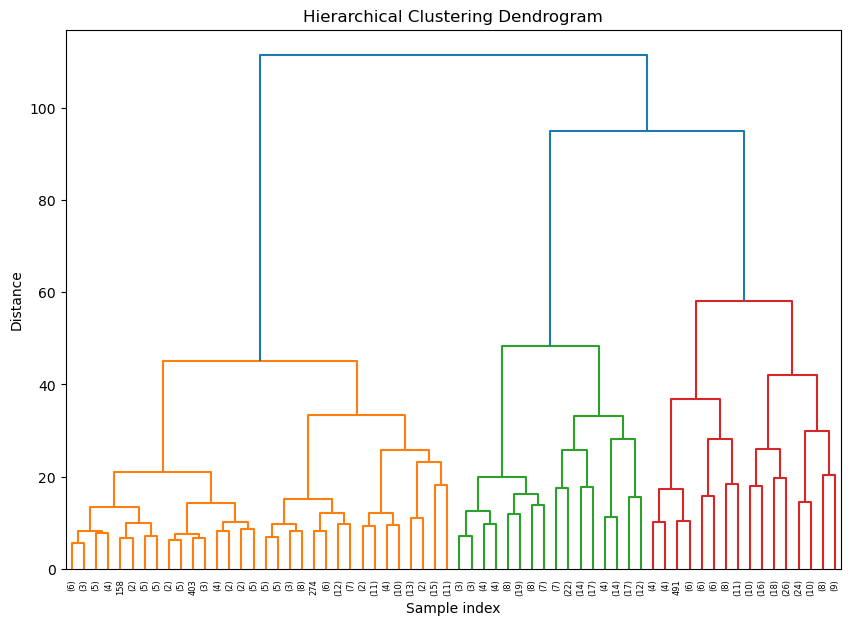

In [4]:
from scipy.cluster.hierarchy import dendrogram, linkage

def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

def calculate_distance_matrix(X):
    n = len(X)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            dist_matrix[i, j] = euclidean_distance(X[i], X[j])
            dist_matrix[j, i] = dist_matrix[i, j]
    return dist_matrix

def hierarchical_clustering(X, num_clusters):
    n = len(X)
    clusters = [[i] for i in range(n)]
    distance_matrix = calculate_distance_matrix(X)

    while len(clusters) > num_clusters:
        min_dist = float('inf')
        to_merge = None
        
        # Find closest clusters to merge
        for i in range(len(clusters)):
            for j in range(i + 1, len(clusters)):
                dist = np.mean([distance_matrix[p1][p2] for p1 in clusters[i] for p2 in clusters[j]])
                if dist < min_dist:
                    min_dist = dist
                    to_merge = (i, j)

        # Merge clusters
        clusters[to_merge[0]].extend(clusters[to_merge[1]])
        clusters.pop(to_merge[1])

    # Assign cluster labels
    labels = np.zeros(n)
    for cluster_id, cluster in enumerate(clusters):
        for index in cluster:
            labels[index] = cluster_id
    return labels

# Run Hierarchical Clustering
num_clusters = 10
labels_hierarchical = hierarchical_clustering(X, num_clusters)

# Generate linkage matrix for the dendrogram
Z = linkage(X, method='ward')

# Plot dendrogram
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
dendrogram(Z, truncate_mode='level', p=5)  # Truncate for simplicity
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.show()


In [ ]:
def get_neighbors(X, point_idx, eps):
    neighbors = []
    for i in range(len(X)):
        if euclidean_distance(X[point_idx], X[i]) <= eps:
            neighbors.append(i)
    return neighbors

def dbscan(X, eps, min_samples):
    labels = [-1] * len(X)  # Initialize all points as noise
    cluster_id = 0
    
    for i in range(len(X)):
        if labels[i] != -1:
            continue  # Skip already clustered points

        # Find neighbors
        neighbors = get_neighbors(X, i, eps)
        if len(neighbors) < min_samples:
            continue  # Keep as noise
        labels[i] = cluster_id
        
        # Expand cluster
        queue = list(neighbors)
        while queue:
            neighbor = queue.pop(0)
            if labels[neighbor] == -1:  # Previously marked noise, now becomes a border point
                labels[neighbor] = cluster_id
            elif labels[neighbor] != -1:  # Already in a cluster
                continue

            # Expand to additional neighbors if it's a core point
            neighbor_neighbors = get_neighbors(X, neighbor, eps)
            if len(neighbor_neighbors) >= min_samples:
                queue.extend(neighbor_neighbors)

        cluster_id += 1
    return labels

# Run DBSCAN
eps = 5  # Distance threshold
min_samples = 5  # Minimum points to form a dense region
labels_dbscan = dbscan(X, eps, min_samples)
    

In [6]:
def silhouette_score(X, labels):
    n = len(X)
    silhouette_scores = np.zeros(n)

    for i in range(n):
        same_cluster = [j for j in range(n) if labels[j] == labels[i] and i != j]
        other_cluster = [j for j in range(n) if labels[j] != labels[i]]

        # Calculate a (intra-cluster distance)
        a = np.mean([euclidean_distance(X[i], X[j]) for j in same_cluster]) if same_cluster else 0
        # Calculate b (nearest-cluster distance)
        b = np.min([np.mean([euclidean_distance(X[i], X[j]) for j in other_cluster])])

        silhouette_scores[i] = (b - a) / max(a, b)
    
    return np.mean(silhouette_scores)

silhouette_hierarchical = silhouette_score(X, labels_hierarchical)
silhouette_dbscan = silhouette_score(X, labels_dbscan)

print("Silhouette Score (Hierarchical):", silhouette_hierarchical)
print("Silhouette Score (DBSCAN):", silhouette_dbscan)


Silhouette Score (Hierarchical): 0.2669621542138036
Silhouette Score (DBSCAN): 0.12252498139617518


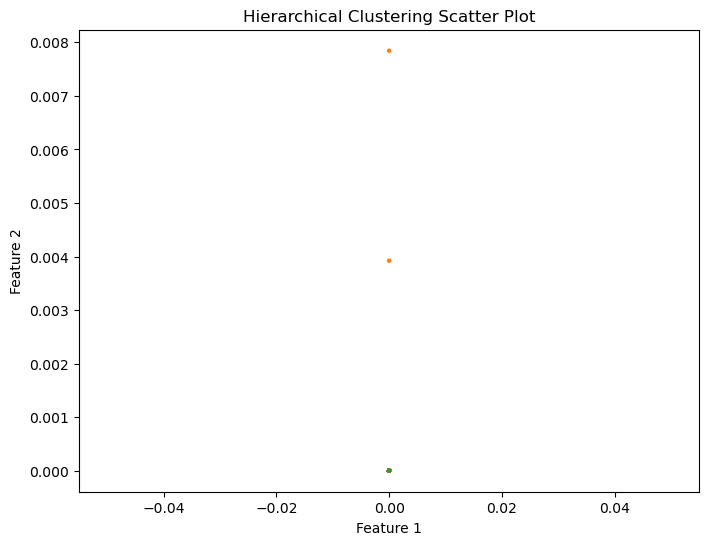

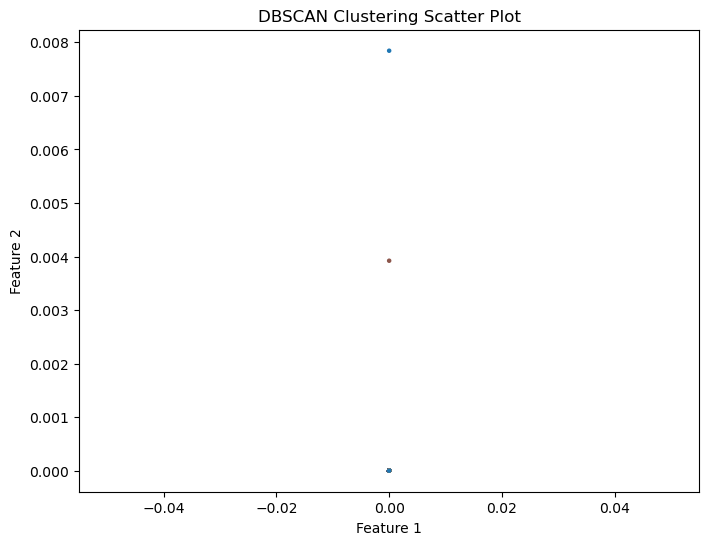

In [7]:
# Scatter plot for Hierarchical Clustering
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels_hierarchical, cmap='tab10', s=5)
plt.title("Hierarchical Clustering Scatter Plot")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

# Scatter plot for DBSCAN
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels_dbscan, cmap='tab10', s=5)
plt.title("DBSCAN Clustering Scatter Plot")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()
